<a href="https://colab.research.google.com/github/AliceKitchkin/Unsupervised-Machine-Learning/blob/main/CustomerSegmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Wichtiges Zeug vor dem Clustern O.o

---

##1. Dataset Features

**People:**
* `ID`: Customer's unique identifier
* `Year_Birth`: Customer's birth year
* `Education`: Customer's education level
* `Marital_Status`: Customer's marital status
* `Income`: Customer's yearly household income
* `Kidhome`: Number of children in customer's household
* `Teenhome`: Number of teenagers in customer's household
* `Dt_Customer`: Date of customer's enrollment with the company
* `Recency`: Number of days since customer's last purchase
* `Complain`: 1 if the customer complained in the last 2 years, 0 otherwise

**Products:**
* `MntWines`: Amount spent on wine in last 2 years
* `MntFruits`: Amount spent on fruits in last 2 years
* `MntMeatProducts`: Amount spent on meat in last 2 years
* `MntFishProducts`: Amount spent on fish in last 2 years
* `MntSweetProducts`: Amount spent on sweets in last 2 years
* `MntGoldProds`: Amount spent on gold in last 2 years

**Promotion:**
* `NumDealsPurchases`: Number of purchases made with a discount
* `AcceptedCmp1`: 1 if customer accepted the offer in the 1st campaign, 0 otherwise
* `AcceptedCmp2`: 1 if customer accepted the offer in the 2nd campaign, 0 otherwise
* `AcceptedCmp3`: 1 if customer accepted the offer in the 3rd campaign, 0 otherwise
* `AcceptedCmp4`: 1 if customer accepted the offer in the 4th campaign, 0 otherwise
* `AcceptedCmp5`: 1 if customer accepted the offer in the 5th campaign, 0 otherwise
* `Response`: 1 if customer accepted the offer in the last campaign, 0 otherwise

**Place:**
* `NumWebPurchases`: Number of purchases made through the company’s website
* `NumCatalogPurchases`: Number of purchases made using a catalogue
* `NumStorePurchases`: Number of purchases made directly in stores
* `NumWebVisitsMonth`: Number of visits to company’s website in the last month

##2. Import Libraries And Data

In [2]:
# handle table-like data and matrices
import pandas as pd
import numpy as np

# visualisation
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

# preprocessing
from sklearn.preprocessing import StandardScaler

# pca
from sklearn.decomposition import PCA

# clustering
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans, AgglomerativeClustering

# evaluations
from sklearn.metrics import confusion_matrix

# ignore warnings
import warnings
warnings.filterwarnings('ignore')

# to display the total number columns present in the dataset
pd.set_option('display.max_columns', None)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
dataraw = pd.read_csv("/content/drive/MyDrive/Bachelorarbeit/CSV/marketing_campaign_raw.csv", sep="\t")
data = dataraw

##3. Handling Missing Values

ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Complain                0
Z_CostContact           0
Z_Revenue               0
Response                0
dtype: int64

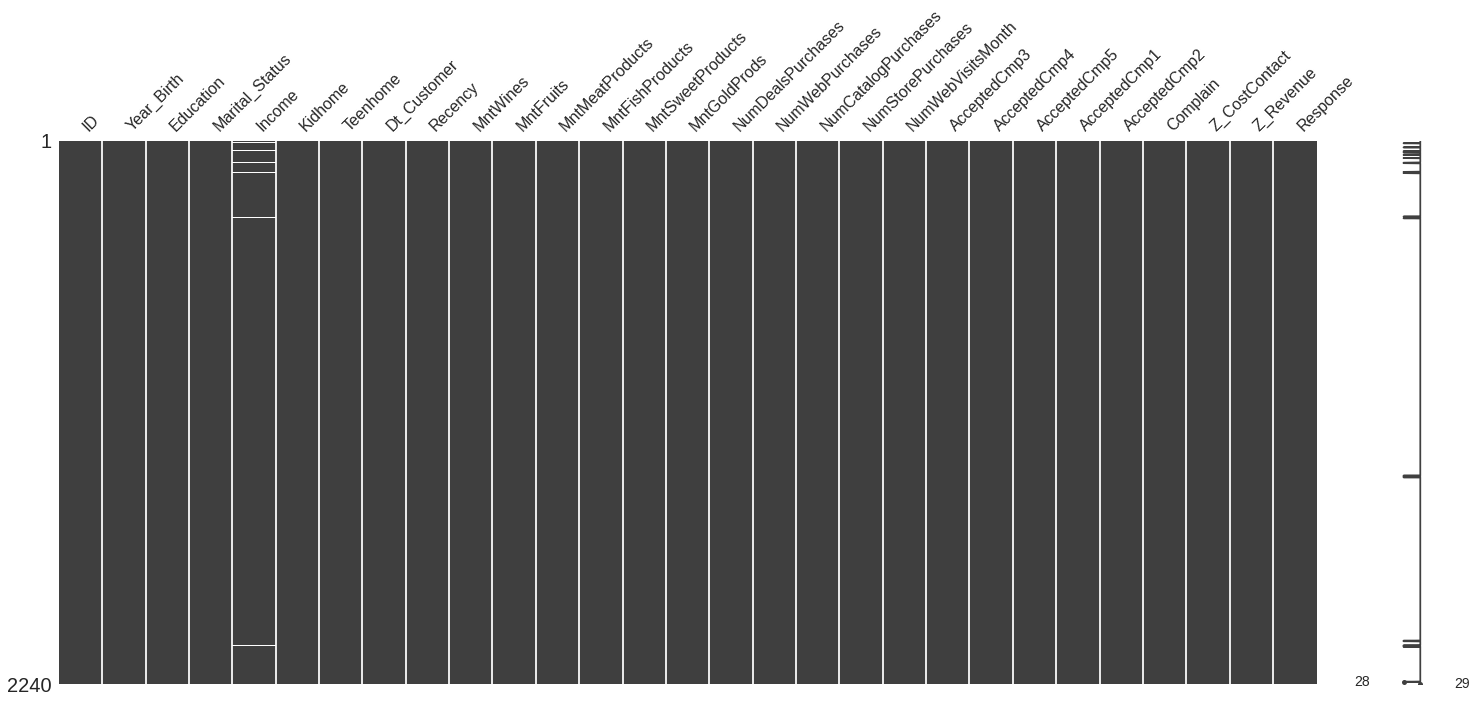

In [5]:
#vorher
msno.matrix(dataraw)
dataraw.isnull().sum()

In [6]:
#drop NA
data = data.dropna()

ID                     0
Year_Birth             0
Education              0
Marital_Status         0
Income                 0
Kidhome                0
Teenhome               0
Dt_Customer            0
Recency                0
MntWines               0
MntFruits              0
MntMeatProducts        0
MntFishProducts        0
MntSweetProducts       0
MntGoldProds           0
NumDealsPurchases      0
NumWebPurchases        0
NumCatalogPurchases    0
NumStorePurchases      0
NumWebVisitsMonth      0
AcceptedCmp3           0
AcceptedCmp4           0
AcceptedCmp5           0
AcceptedCmp1           0
AcceptedCmp2           0
Complain               0
Z_CostContact          0
Z_Revenue              0
Response               0
dtype: int64

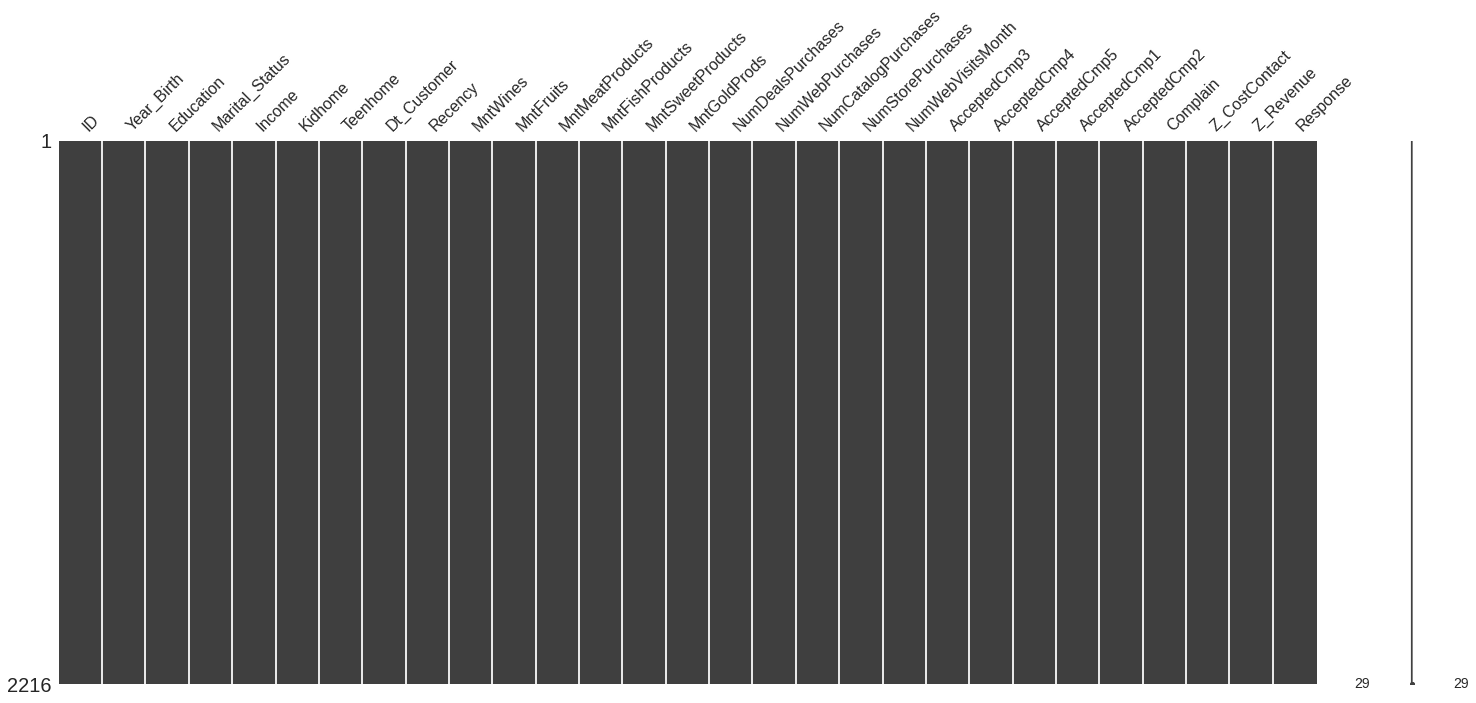

In [7]:
#danach
msno.matrix(data)
data.isnull().sum()

##4. Feature Engineering

In [8]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2216 entries, 0 to 2239
Data columns (total 29 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2216 non-null   int64  
 1   Year_Birth           2216 non-null   int64  
 2   Education            2216 non-null   object 
 3   Marital_Status       2216 non-null   object 
 4   Income               2216 non-null   float64
 5   Kidhome              2216 non-null   int64  
 6   Teenhome             2216 non-null   int64  
 7   Dt_Customer          2216 non-null   object 
 8   Recency              2216 non-null   int64  
 9   MntWines             2216 non-null   int64  
 10  MntFruits            2216 non-null   int64  
 11  MntMeatProducts      2216 non-null   int64  
 12  MntFishProducts      2216 non-null   int64  
 13  MntSweetProducts     2216 non-null   int64  
 14  MntGoldProds         2216 non-null   int64  
 15  NumDealsPurchases    2216 non-null   i

In [9]:
#the date a customer joined the database is not parsed as DateTime
data['Dt_Customer'] = pd.to_datetime(data['Dt_Customer'])

In [10]:
#Extract the "Age" of a customer by the "Year_Birth" indicating the birth year of the respective person
data['Age'] = 2022 - data['Year_Birth']

In [11]:
#Create another feature "Spent" indicating the total amount spent by the customer in various categories over the span of two years
data['Spent'] = data['MntWines'] + data['MntFruits'] + data['MntMeatProducts'] + data['MntFishProducts'] + data['MntSweetProducts'] + data['MntGoldProds']

In [12]:
#Create another feature "Living_With" out of "Marital_Status" to extract the living situation of couples
data['Living_With'] = data['Marital_Status'].replace({'Married':'Partner', 'Together':'Partner', 'Absurd':'Alone', 'Widow':'Alone', 'YOLO':'Alone', 'Divorced':'Alone', 'Single':'Alone'})

In [13]:
#Create a feature "Children" to indicate total children in a household that is, kids and teenagers.
data['Children'] = data['Kidhome'] + data['Teenhome']

In [14]:
#To get further clarity of household, Creating feature indicating "Family_Size"
data['Family_Size'] = data['Living_With'].replace({'Alone': 1, 'Partner':2}) + data['Children']

In [15]:
#Create a feature "Is_Parent" to indicate parenthood status
data['Is_Parent'] = np.where(data.Children > 0, 1, 0)

In [16]:
#Segmenting education levels in three groups
data['Education'] = data['Education'].replace({'Basic':'Undergraduate', '2n Cycle':'Undergraduate', 'Graduation':'Graduate', 'Master':'Postgraduate', 'PhD':'Postgraduate'})

In [17]:
#Dropping some of the redundant features
to_drop = ['Marital_Status', 'Dt_Customer', 'Z_CostContact', 'Z_Revenue', 'Year_Birth', 'ID']
data = data.drop(to_drop, axis=1)

In [18]:
data.head(10)

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,Graduate,58138.0,0,0,58,635,88,546,172,88,88,3,8,10,4,7,0,0,0,0,0,0,1,65,1617,Alone,0,1,0
1,Graduate,46344.0,1,1,38,11,1,6,2,1,6,2,1,1,2,5,0,0,0,0,0,0,0,68,27,Alone,2,3,1
2,Graduate,71613.0,0,0,26,426,49,127,111,21,42,1,8,2,10,4,0,0,0,0,0,0,0,57,776,Partner,0,2,0
3,Graduate,26646.0,1,0,26,11,4,20,10,3,5,2,2,0,4,6,0,0,0,0,0,0,0,38,53,Partner,1,3,1
4,Postgraduate,58293.0,1,0,94,173,43,118,46,27,15,5,5,3,6,5,0,0,0,0,0,0,0,41,422,Partner,1,3,1
5,Postgraduate,62513.0,0,1,16,520,42,98,0,42,14,2,6,4,10,6,0,0,0,0,0,0,0,55,716,Partner,1,3,1
6,Graduate,55635.0,0,1,34,235,65,164,50,49,27,4,7,3,7,6,0,0,0,0,0,0,0,51,590,Alone,1,2,1
7,Postgraduate,33454.0,1,0,32,76,10,56,3,1,23,2,4,0,4,8,0,0,0,0,0,0,0,37,169,Partner,1,3,1
8,Postgraduate,30351.0,1,0,19,14,0,24,3,3,2,1,3,0,2,9,0,0,0,0,0,0,1,48,46,Partner,1,3,1
9,Postgraduate,5648.0,1,1,68,28,0,6,1,1,13,1,1,0,0,20,1,0,0,0,0,0,0,72,49,Partner,2,4,1


##5. Data Analysis And Visualization


In [19]:
data.shape
#There are 2216 cutomers and 29 features in the dataset.

(2216, 29)

In [20]:
#returns the statistical summary of the dataframe or series
data.describe()

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Age,Spent,Children,Family_Size,Is_Parent
count,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000,2216.000000
mean,52247.251354,0.441787,0.505415,49.012635,305.091606,26.356047,166.995939,37.637635,27.028881,43.965253,2.323556,4.085289,2.671029,5.800993,5.319043,0.073556,0.074007,0.073105,0.064079,0.013538,0.009477,0.150271,53.179603,607.075361,0.947202,2.592509,0.714350
std,25173.076661,0.536896,0.544181,28.948352,337.327920,39.793917,224.283273,54.752082,41.072046,51.815414,1.923716,2.740951,2.926734,3.250785,2.425359,0.261106,0.261842,0.260367,0.244950,0.115588,0.096907,0.357417,11.985554,602.900476,0.749062,0.905722,0.451825
min,1730.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,26.000000,5.000000,0.000000,1.000000,0.000000
25%,35303.000000,0.000000,0.000000,24.000000,24.000000,2.000000,16.000000,3.000000,1.000000,9.000000,1.000000,2.000000,0.000000,3.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,45.000000,69.000000,0.000000,2.000000,0.000000
50%,51381.500000,0.000000,0.000000,49.000000,174.500000,8.000000,68.000000,12.000000,8.000000,24.500000,2.000000,4.000000,2.000000,5.000000,6.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,52.000000,396.500000,1.000000,3.000000,1.000000
75%,68522.000000,1.000000,1.000000,74.000000,505.000000,33.000000,232.250000,50.000000,33.000000,56.000000,3.000000,6.000000,4.000000,8.000000,7.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,63.000000,1048.000000,1.000000,3.000000,1.000000
max,666666.000000,2.000000,2.000000,99.000000,1493.000000,199.000000,1725.000000,259.000000,262.000000,321.000000,15.000000,27.000000,28.000000,13.000000,20.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,129.000000,2525.000000,3.000000,5.000000,1.000000


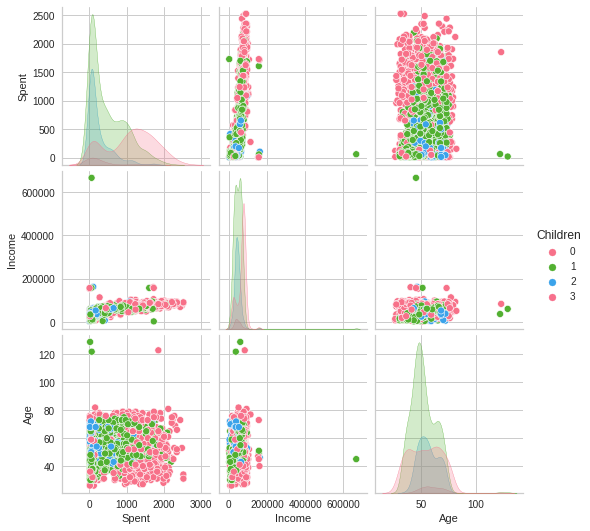

In [21]:
#Plot pairwise relationships in a dataset.
sns.pairplot(data , vars=['Spent','Income','Age'] , hue='Children', palette='husl');

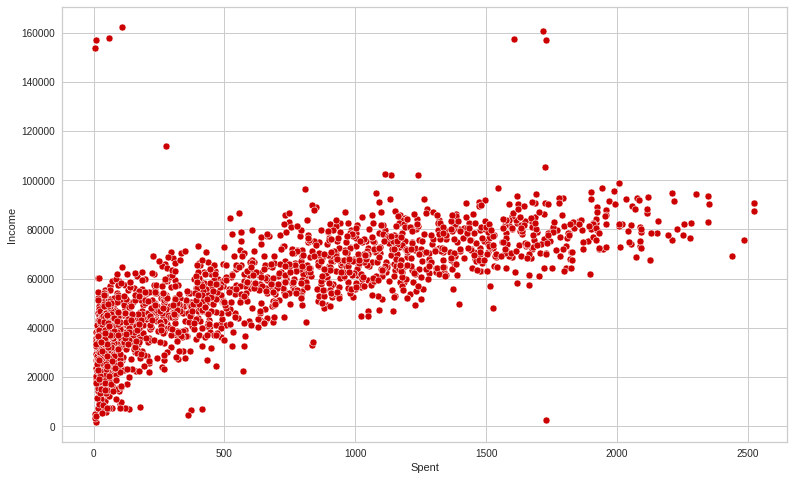

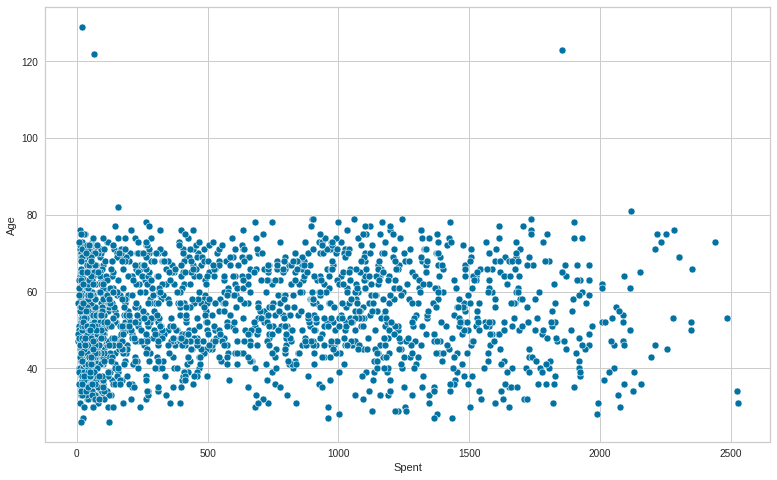

In [22]:
plt.figure(figsize=(13,8))
sns.scatterplot(x=data[data['Income']<600000]['Spent'], y=data[data['Income']<600000]['Income'], color='#cc0000');

plt.figure(figsize=(13,8))
sns.scatterplot(x=data['Spent'], y=data['Age']);

##6. Outlier Detection
The presence of outliers in a classification or regression dataset can result in a poor fit and lower predictive modeling performance, therefore we should see there are ouliers in the data.

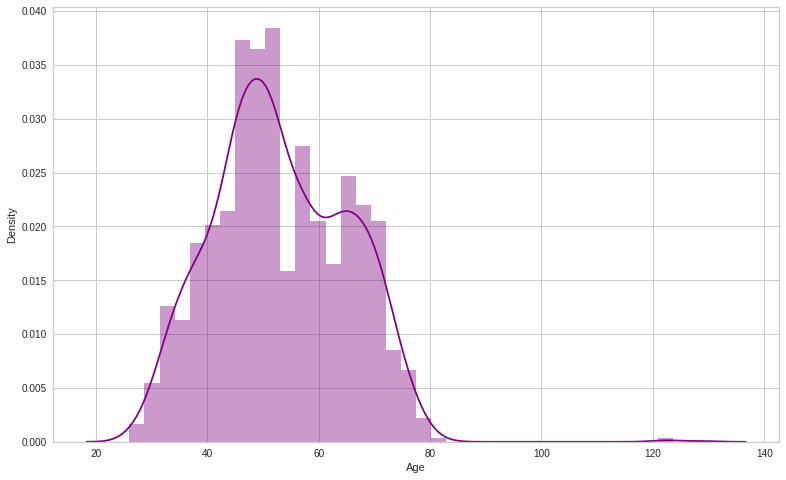

In [23]:
plt.figure(figsize=(13,8))
sns.distplot(data.Age, color='purple');

In [24]:
fig = make_subplots(rows=1, cols=3)

fig.add_trace(go.Box(y=data['Age'], notched=True, name='Age', marker_color = '#6699ff', 
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 2)

fig.add_trace(go.Box(y=data['Income'], notched=True, name='Income', marker_color = '#ff0066', 
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 1)

fig.add_trace(go.Box(y=data['Spent'], notched=True, name='Spent', marker_color = 'lightseagreen', 
                     boxmean=True, boxpoints='suspectedoutliers'), 1, 3)

fig.update_layout(title_text='Box Plots for Numerical Variables')

fig.show()

In [25]:
#delete some of the outlier points
data = data[(data['Age']<100)]
data = data[(data['Income']<600000)]

In [26]:
dataraw.shape

(2240, 29)

In [27]:
data.shape

(2212, 29)

##7. Check For Rare Categories

Some categories may appear a lot in the dataset, whereas some other categories appear only in a few number of observations.

* Rare values in categorical variables tend to cause **over-fitting**, particularly **in tree based methods**.
* Rare labels may be **present in training set, but not in test set**, therefore causing over-fitting to the train set.
* Rare labels may appear **in the test set, and not in the train set**. Thus, the machine learning model will not know how to evaluate it.

In [28]:
categorical = [var for var in data.columns if data[var].dtype=='O']
categorical

['Education', 'Living_With']

In [29]:
#prozentuale Verteilung der Spalten im Bezug zur Gesamtanzahl
for var in categorical:
    print(data[var].value_counts() / np.float(len(data)))
    print()
    print()
#no rare category in the categorical variables

Graduate         0.504069
Postgraduate     0.382007
Undergraduate    0.113924
Name: Education, dtype: float64


Partner    0.64557
Alone      0.35443
Name: Living_With, dtype: float64




###7.1. Categorical Variables Encoding
Encode categorical variables wird ordinal numbers.


In [30]:
categorical

['Education', 'Living_With']

In [31]:
# sicher gehen das nur die bekannten/gewollten labels in den Kategorien existieren
data['Living_With'].unique()
data['Education'].unique()

array(['Graduate', 'Postgraduate', 'Undergraduate'], dtype=object)

In [32]:
#den beiden Kategorien Zahlen zuweisen
data['Living_With'] = data['Living_With'].map({'Alone':0,'Partner':1})

In [33]:
#den drei Kategorien Zahlen zuweisen
data['Education'] = data['Education'].map({'Undergraduate':0,'Graduate':1, 'Postgraduate':2})

In [34]:
data.dtypes

Education                int64
Income                 float64
Kidhome                  int64
Teenhome                 int64
Recency                  int64
MntWines                 int64
MntFruits                int64
MntMeatProducts          int64
MntFishProducts          int64
MntSweetProducts         int64
MntGoldProds             int64
NumDealsPurchases        int64
NumWebPurchases          int64
NumCatalogPurchases      int64
NumStorePurchases        int64
NumWebVisitsMonth        int64
AcceptedCmp3             int64
AcceptedCmp4             int64
AcceptedCmp5             int64
AcceptedCmp1             int64
AcceptedCmp2             int64
Complain                 int64
Response                 int64
Age                      int64
Spent                    int64
Living_With              int64
Children                 int64
Family_Size              int64
Is_Parent                int64
dtype: object

Text(0.5, 1.0, 'Correlation Heatmap')

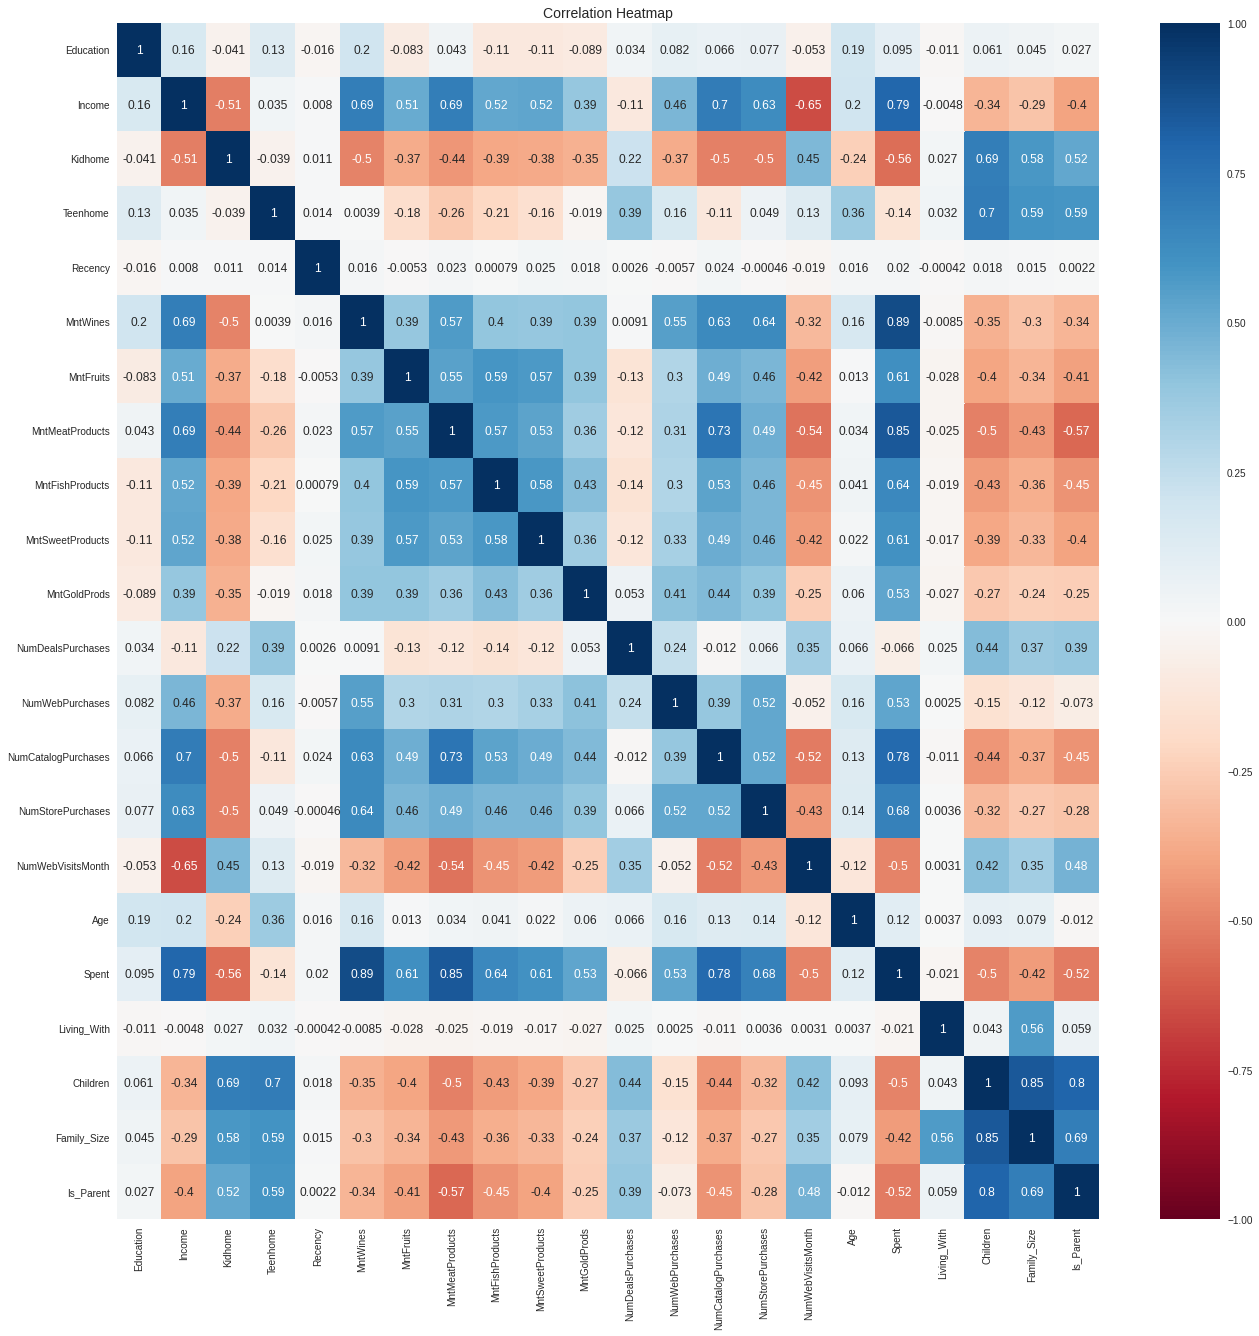

In [140]:
# 0.9 is also a good relationship, and if you increase one value, the other will probably increase as well.
# -0.9 would be just as good relationship as 0.9, but if you increase one value, the other will probably go down.
# 0.2 means NOT a good relationship, meaning that if one value goes up does not mean that the other will.
# 0.6 (or -0.6) is a good correlation

corrmat = data.corr()

plt.figure(figsize=(22,22))  
sns.heatmap(corrmat, annot = True, cmap = 'RdBu', center = 0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap',fontsize=14)

##8. Feature Scaling

In [36]:
data_old = data.copy()

In [37]:
#dropping the features on deals accepted and promotions
cols_del = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5', 'Complain', 'Response']
data = data.drop(cols_del, axis=1)

In [38]:
scaler = StandardScaler()
data = pd.DataFrame(scaler.fit_transform(data), columns = data.columns)

In [95]:
data.head()

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size,Is_Parent
0,-0.411675,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139
1,-0.411675,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456
2,-0.411675,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139
3,-0.411675,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456
4,1.123949,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456


##9. Dimensionality Reduction

###9.1 PCA with 22 Components



Text(0, 0.5, 'Cumulative Explained Variance')

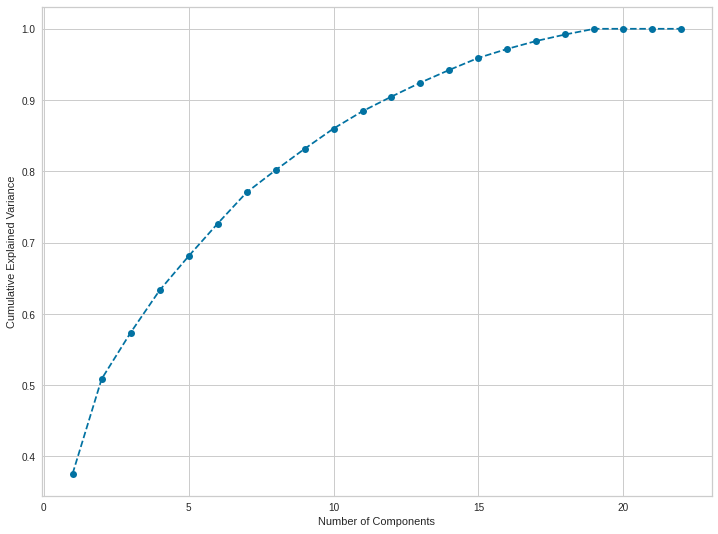

In [152]:
pca = PCA()
pca.fit(data)

#~50% meiner Dimensionen machen 90% der Varianz aus
plt.figure(figsize=(12, 9))
plt.plot(range(1, 23), pca.explained_variance_ratio_.cumsum(), marker='o', linestyle='--')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

###9.2 PCA with 6 Components

"The rule of thumb is to pick the number of components that retain 70–80% of the variability"

In [153]:
pca6 = PCA(n_components=6)
pca6.fit(data)

df_pca6_components = pd.DataFrame(
    data=pca6.components_.round(4),
    columns=data.columns.values,
    index=['component 1', 'component 2', 'component 3', 'component 4', 'component 5', 'component 6'])

df_pca6_components

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size,Is_Parent
component 1,0.0113,0.2795,-0.2462,-0.0987,0.0035,0.2557,0.2384,0.2855,0.2487,0.2373,0.1884,-0.0783,0.1676,0.2773,0.2415,-0.2259,0.0385,0.3201,-0.0276,-0.2481,-0.2197,-0.2428
component 2,0.1407,0.1782,0.0052,0.4621,0.0163,0.2094,0.0111,0.0099,0.0003,0.0216,0.1231,0.3487,0.2968,0.1060,0.2055,0.0461,0.2348,0.1337,0.1255,0.3393,0.3469,0.2923
component 3,-0.5068,-0.0754,0.2829,-0.1516,0.0359,-0.1169,0.2541,0.0765,0.2539,0.2577,0.1995,0.1523,0.0229,0.0170,-0.0073,0.0911,-0.4287,0.0376,0.3004,0.0926,0.2352,0.0820
component 4,-0.1559,-0.1627,-0.0262,-0.0248,-0.0446,0.0723,-0.0164,-0.0991,-0.0300,-0.0233,0.2254,0.3428,0.3195,-0.0453,0.0574,0.3833,-0.1537,0.0175,-0.5962,-0.0368,-0.3452,0.0815
component 5,0.3800,-0.0326,0.0919,-0.3174,-0.3476,0.2650,-0.1681,0.0835,-0.1780,-0.1895,-0.0869,0.1590,0.1883,0.0549,0.0455,0.2669,-0.3386,0.1318,0.3710,-0.1647,0.0597,-0.0812
component 6,0.2566,0.0545,0.2438,-0.1414,0.8312,0.1227,-0.0679,0.1598,-0.0691,-0.0375,-0.1035,0.0866,-0.0562,0.1033,-0.0394,0.0150,-0.2124,0.1060,-0.1190,0.0720,-0.0032,0.0068


Text(0.5, 1.0, 'Correlation Heatmap')

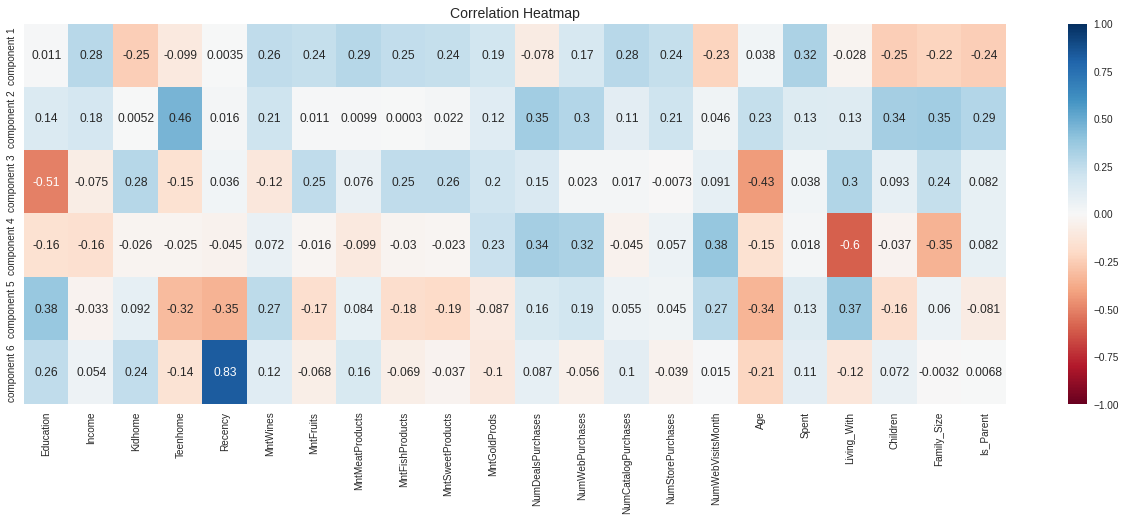

In [154]:
# 0.9 is also a good relationship, and if you increase one value, the other will probably increase as well.
# -0.9 would be just as good relationship as 0.9, but if you increase one value, the other will probably go down.
# 0.2 means NOT a good relationship, meaning that if one value goes up does not mean that the other will.
# 0.6 (or -0.6) is a good correlation

plt.figure(figsize=(22,7))  
sns.heatmap(df_pca6_components, annot = True, cmap = 'RdBu', center = 0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap',fontsize=14)

**Component 1**
> negative correlations (all under -0.30)
*   kidHome
*   NumWebVisitsMonth
*   Children
*   Family_Size
*   Is_Parent

> positve correlations (all over +0.30)
*   Income
*   MntWines
*   MntFruits
*   MntMeatProducts
*   MntFishProducts
*   MntSweetProducts
*   NumCatalogPurchases
*   NumStorePurchases
*   spent

**Component 2**
> negative correlations
*   teenhome
*   NumWebVisitsMonth
*   Children
*   Family_Size
*   Is_Parent

> positve correlations
*   Income
*   MntWines
*   MntFruits
*   MntMeatProducts
*   MntFishProducts
*   MntSweetProducts
*   NumCatalogPurchases
*   NumStorePurchases
*   spent



###9.3 PCA with 3 Components

In [155]:
pca3 = PCA(n_components=3)
pca3.fit(data)

df_pca3_components = pd.DataFrame(
    data=pca3.components_.round(4),
    columns=data.columns.values,
    index=['component 1', 'component 2', 'component 3'])

df_pca3_components

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size,Is_Parent
component 1,0.0113,0.2795,-0.2462,-0.0987,0.0035,0.2557,0.2384,0.2855,0.2487,0.2373,0.1884,-0.0783,0.1676,0.2773,0.2415,-0.2259,0.0385,0.3201,-0.0276,-0.2481,-0.2197,-0.2428
component 2,0.1407,0.1782,0.0052,0.4621,0.0163,0.2094,0.0111,0.0099,0.0002,0.0217,0.1231,0.3487,0.2968,0.1060,0.2055,0.0461,0.2348,0.1337,0.1255,0.3393,0.3469,0.2923
component 3,-0.5068,-0.0753,0.2830,-0.1517,0.0359,-0.1171,0.2542,0.0765,0.2539,0.2574,0.1995,0.1523,0.0235,0.0168,-0.0074,0.0908,-0.4287,0.0375,0.3004,0.0926,0.2352,0.0820


Text(0.5, 1.0, 'Correlation Heatmap')

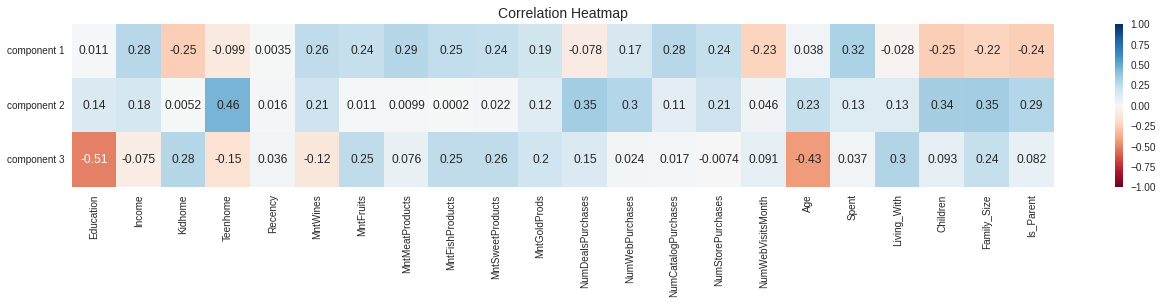

In [156]:
# 0.9 is also a good relationship, and if you increase one value, the other will probably increase as well.
# -0.9 would be just as good relationship as 0.9, but if you increase one value, the other will probably go down.
# 0.2 means NOT a good relationship, meaning that if one value goes up does not mean that the other will.
# 0.6 (or -0.6) is a good correlation

plt.figure(figsize=(22,3))  
sns.heatmap(df_pca3_components, annot = True, cmap = 'RdBu', center = 0, vmin=-1, vmax=1)
plt.title('Correlation Heatmap',fontsize=14)

##10. Clustering

###10.1 Elbow Method One

In [211]:
results = {}

for i in range (1, 23):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(data)
    results[i] = kmeans.inertia_

results

{1: 48664.00000000002,
 2: 34446.16287428921,
 3: 29948.51002056998,
 4: 27544.91205931273,
 5: 26147.763972241915,
 6: 24943.297806701186,
 7: 24019.779887812725,
 8: 23163.042729307068,
 9: 22345.080042940805,
 10: 21874.529989570045,
 11: 21281.392339294056,
 12: 20853.077862460937,
 13: 20607.55521302719,
 14: 20293.57479983333,
 15: 19884.247901629908,
 16: 19615.655034716023,
 17: 19316.62033214722,
 18: 18959.243027751887,
 19: 18630.811192464986,
 20: 18485.086333081592,
 21: 18449.46552170047,
 22: 18116.966174831032}

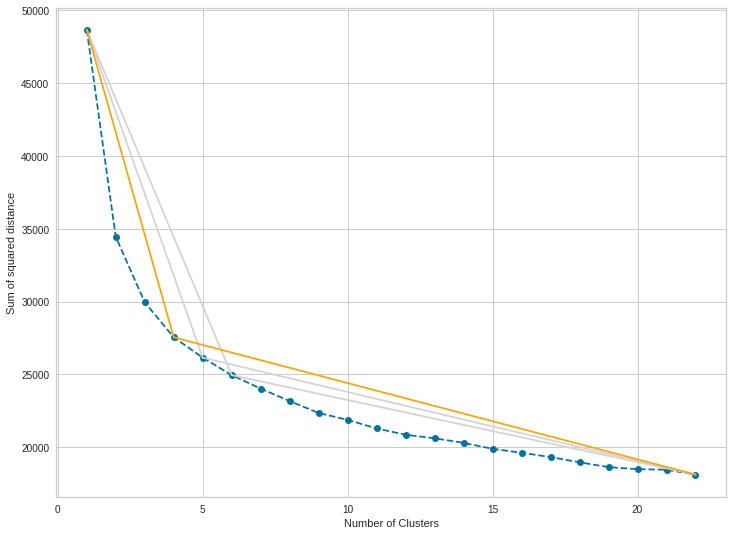

In [225]:
plt.figure(figsize=(12, 9))
plt.plot(list(results.keys()), list(results.values()), marker='o', linestyle='--')

plt.plot([1, 5], [results[1], results[5]], color='lightgrey')
plt.plot([5, 22], [results[5], results[22]], color='lightgrey')

plt.plot([1, 6], [results[1], results[6]], color='lightgrey')
plt.plot([6, 22], [results[6], results[22]], color='lightgrey')

plt.plot([1, 4], [results[1], results[4]], color='orange')
plt.plot([4, 22], [results[4], results[22]], color='orange')

plt.xlabel('Number of Clusters')
plt.ylabel('Sum of squared distance')
plt.show()

###10.2 Elbow Method Two

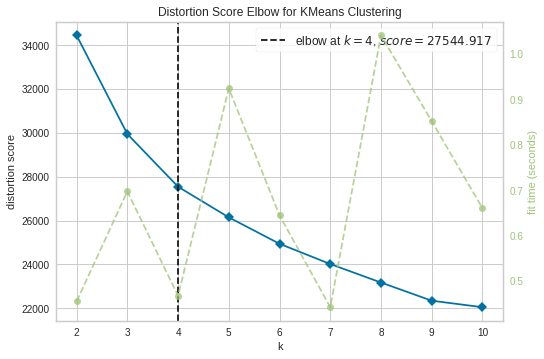

In [202]:
Elbow_M = KElbowVisualizer(KMeans(), k=10)
Elbow_M.fit(data)
Elbow_M.show();

###10.3 K-Means

In [226]:
kmeans = KMeans(n_clusters=4, init='k-means++', random_state=42)
kmeans.fit(data)

KMeans(n_clusters=4, random_state=42)

In [231]:
data_kmeans = data.copy()
data_kmeans['Clusters'] = kmeans.labels_
data_kmeans

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size,Is_Parent,Clusters
0,-0.411675,0.287105,-0.822754,-0.929699,0.310353,0.977660,1.552041,1.690293,2.453472,1.483713,0.852576,0.351030,1.426865,2.503607,-0.555814,0.692181,1.018352,1.676245,-1.349603,-1.264598,-1.758359,-1.581139,0
1,-0.411675,-0.260882,1.040021,0.908097,-0.380813,-0.872618,-0.637461,-0.718230,-0.651004,-0.634019,-0.733642,-0.168701,-1.126420,-0.571340,-1.171160,-0.132545,1.274785,-0.963297,-1.349603,1.404572,0.449070,0.632456,2
2,-0.411675,0.913196,-0.822754,-0.929699,-0.795514,0.357935,0.570540,-0.178542,1.339513,-0.147184,-0.037254,-0.688432,1.426865,-0.229679,1.290224,-0.544908,0.334530,0.280110,0.740959,-1.264598,-0.654644,-1.581139,0
3,-0.411675,-1.176114,1.040021,-0.929699,-0.795514,-0.872618,-0.561961,-0.655787,-0.504911,-0.585335,-0.752987,-0.168701,-0.761665,-0.913000,-0.555814,0.279818,-1.289547,-0.920135,0.740959,0.069987,0.449070,0.632456,1
4,1.123949,0.294307,1.040021,-0.929699,1.554453,-0.392257,0.419540,-0.218684,0.152508,-0.001133,-0.559545,1.390492,0.332600,0.111982,0.059532,-0.132545,-1.033114,-0.307562,0.740959,0.069987,0.449070,0.632456,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2207,-0.411675,0.430444,-0.822754,0.908097,-0.104347,1.197084,0.419540,0.066770,0.079461,2.213965,3.928291,-0.168701,1.791619,0.111982,-0.555814,-0.132545,0.163575,1.218061,0.740959,0.069987,0.449070,0.632456,3
2208,1.123949,0.560123,2.902796,0.908097,0.241237,0.298631,-0.662628,-0.611184,-0.687527,-0.658360,-0.694954,2.429954,1.426865,-0.229679,-0.248141,0.692181,1.958607,-0.271040,0.740959,2.739158,2.656499,0.632456,2
2209,-0.411675,0.233347,-0.822754,-0.929699,1.450778,1.787156,0.545373,0.222878,-0.103155,-0.366260,-0.385448,-0.688432,-0.761665,0.111982,2.213242,0.279818,-1.033114,1.052052,-1.349603,-1.264598,-1.758359,-1.581139,0
2210,1.123949,0.803172,-0.822754,0.908097,-1.417564,0.363866,0.092373,0.209498,0.773403,0.071892,0.330284,-0.168701,0.697355,0.795303,1.290224,-0.957271,1.103830,0.391336,0.740959,0.069987,0.449070,0.632456,3


In [232]:
data_analysis = data_kmeans.groupby('Clusters').mean().round(3)
data_analysis

,Education,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,NumDealsPurchases,NumWebPurchases,NumCatalogPurchases,NumStorePurchases,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size,Is_Parent
Clusters,,,,,,,,,,,,,,,,,,,,,,
0,0.054,1.113,-0.804,-0.901,0.023,0.890,0.948,1.342,1.027,0.929,0.572,-0.617,0.318,1.126,0.751,-1.088,0.062,1.266,-0.127,-1.230,-1.085,-1.524
1,-0.282,-1.010,0.576,-0.855,-0.004,-0.791,-0.495,-0.621,-0.496,-0.490,-0.479,-0.233,-0.651,-0.722,-0.796,0.625,-0.665,-0.826,-0.035,-0.208,-0.191,0.149
2,0.176,-0.430,0.680,0.969,0.005,-0.667,-0.561,-0.619,-0.585,-0.561,-0.546,0.242,-0.570,-0.648,-0.653,0.302,0.390,-0.779,0.120,1.191,1.048,0.632
3,0.096,0.476,-0.507,0.841,-0.020,0.649,0.189,0.028,0.143,0.202,0.489,0.575,0.916,0.352,0.764,0.025,0.306,0.455,0.043,0.248,0.228,0.621


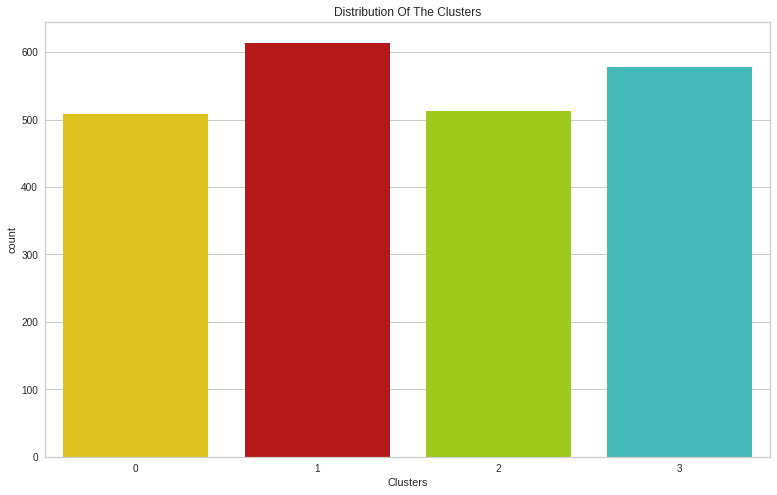

In [233]:
pal = ['gold','#cc0000', '#ace600','#33cccc']
plt.figure(figsize=(13,8))
pl = sns.countplot(x=data_kmeans['Clusters'], palette= pal)
pl.set_title('Distribution Of The Clusters')
plt.show()

###10.4 AC?

In [234]:
AC = AgglomerativeClustering(n_clusters=4)
# fit model and predict clusters
yhat_AC = AC.fit_predict(data_PCA)
data_PCA['Clusters'] = yhat_AC
#Adding the Clusters feature to the orignal dataframe.
data['Clusters'] = yhat_AC
data_old['Clusters'] = yhat_AC

In [236]:
data_PCA

,col1,col2,col3,Clusters
0,4.908733,-0.537790,0.446080,3
1,-2.865084,0.131302,-0.984447,1
2,2.597497,-0.780253,-0.043383,3
3,-2.650425,-1.456926,1.059341,2
4,-0.600206,0.438515,0.987432,0
...,...,...,...,...
2207,2.284871,2.242886,1.521554,0
2208,-3.028236,4.425824,0.111912,0
2209,2.672403,-1.858754,-0.791653,3
2210,1.547935,2.037536,-0.938842,0


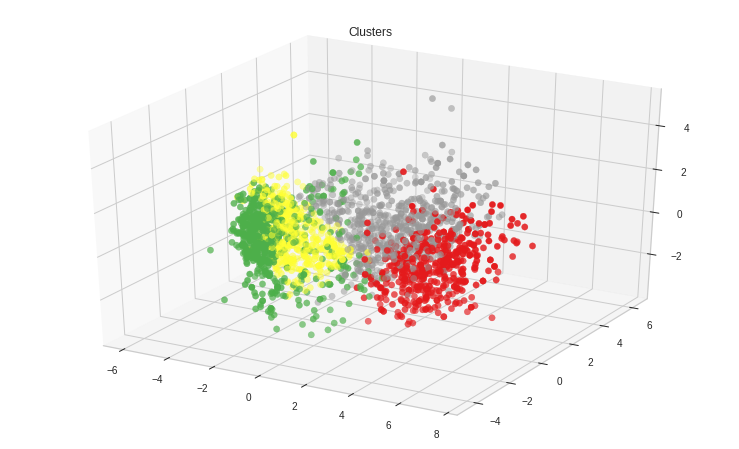

In [235]:
fig = plt.figure(figsize=(13,8))
ax = plt.subplot(111, projection='3d', label='bla')
ax.scatter(x, y, z, s=40, c=data_PCA['Clusters'], marker='o', cmap='Set1_r')
ax.set_title('Clusters')
plt.show()